In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Reading Titanic training and test datasets
train_data = pd.read_csv('Titanic_train.csv')
test_data = pd.read_csv('Titanic_test.csv')

In [5]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


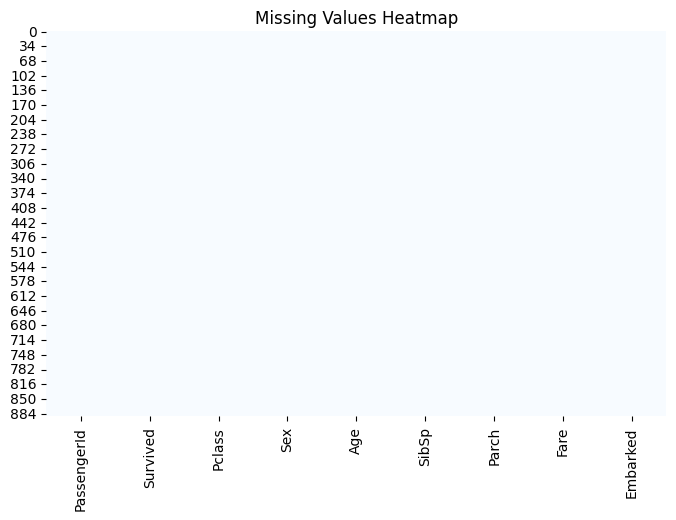

In [51]:
# Visualizing missing values to identify incomplete columns before preprocessing
plt.figure(figsize=(8, 5))
sns.heatmap(train_data.isnull(), cmap='Blues', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

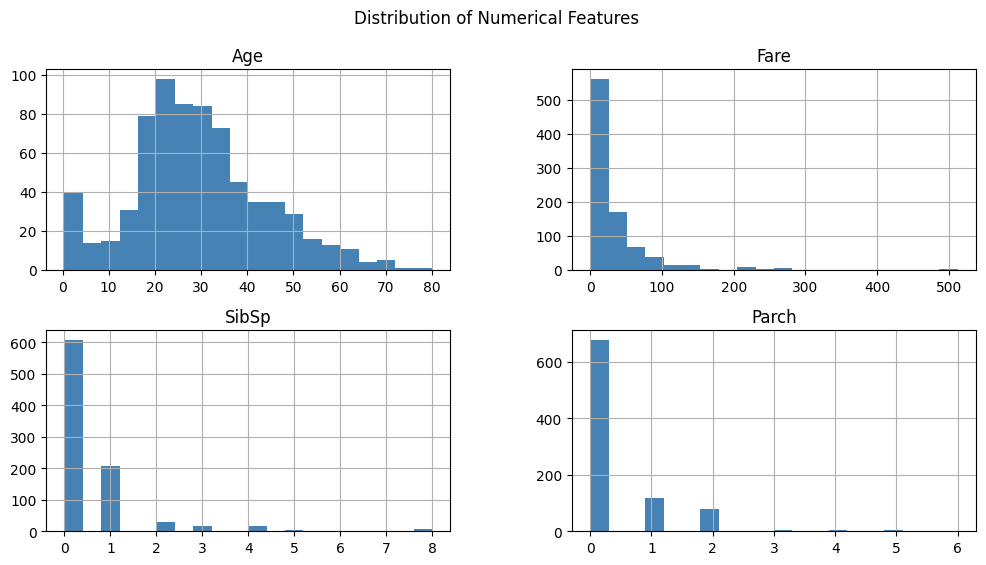

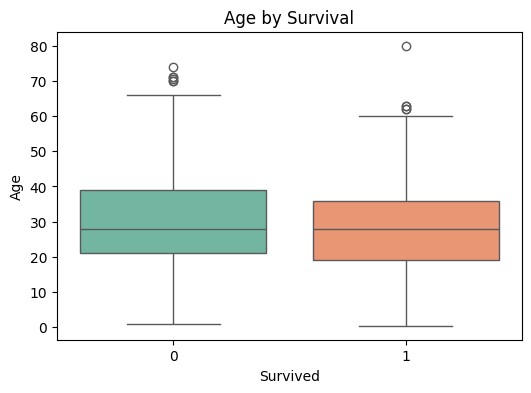

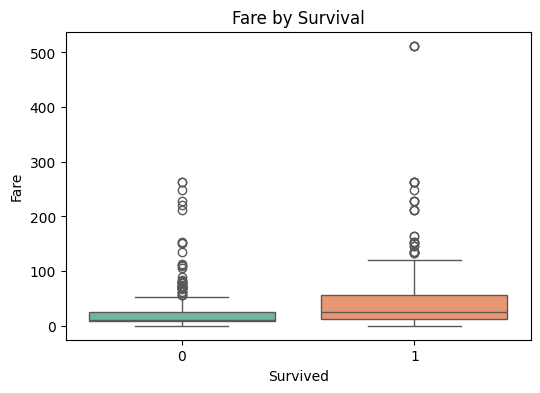

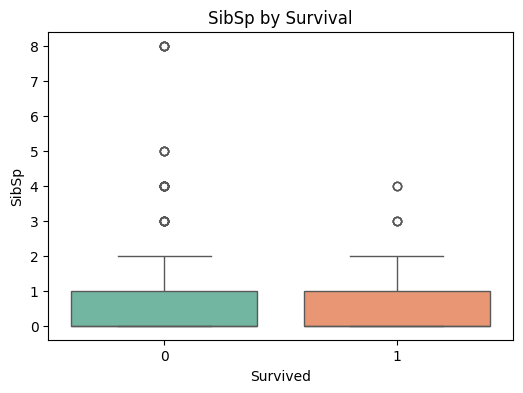

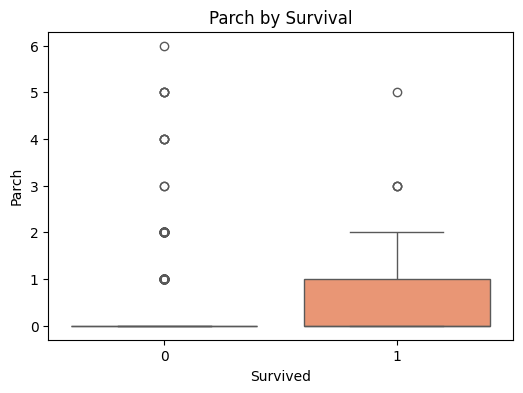

In [9]:
# Selecting numerical features to explore their distributions and survival impact
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

# Plotting histograms to inspect spread and skewness
train_data[numerical_features].hist(bins=20, figsize=(12, 6), color='steelblue')
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Comparing distributions between survivors and non-survivors
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Survived', y=feature, data=train_data, palette='Set2')
    plt.title(f'{feature} by Survival')
    plt.show()

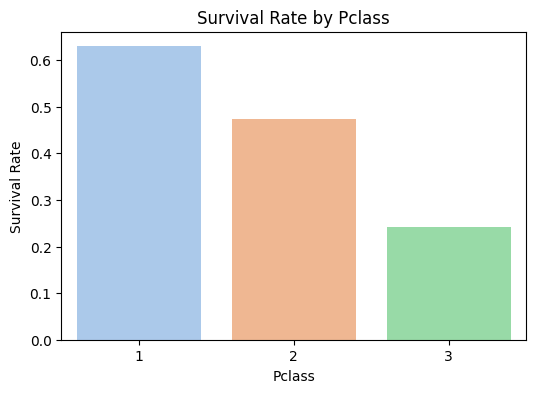

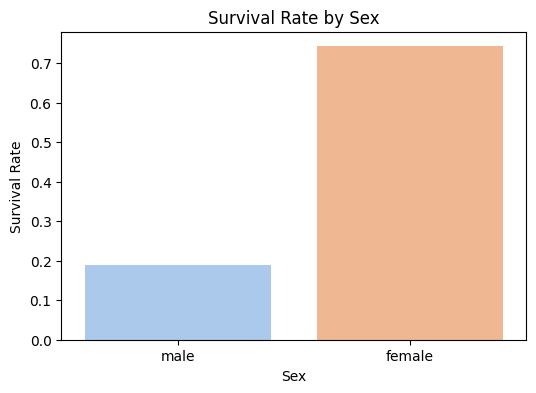

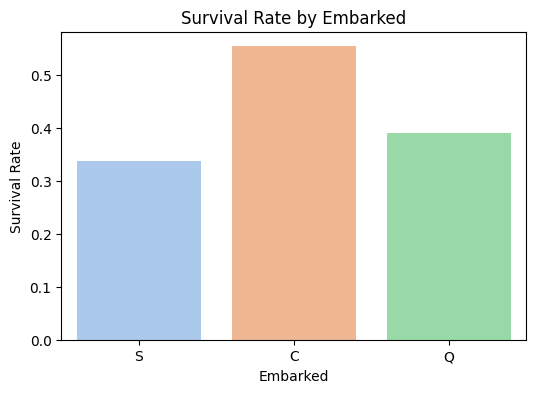

In [10]:
# Exploring how categorical features relate to survival
categorical_features = ['Pclass', 'Sex', 'Embarked']

for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=feature, y='Survived', data=train_data, ci=None, palette='pastel')
    plt.title(f'Survival Rate by {feature}')
    plt.ylabel('Survival Rate')
    plt.show()

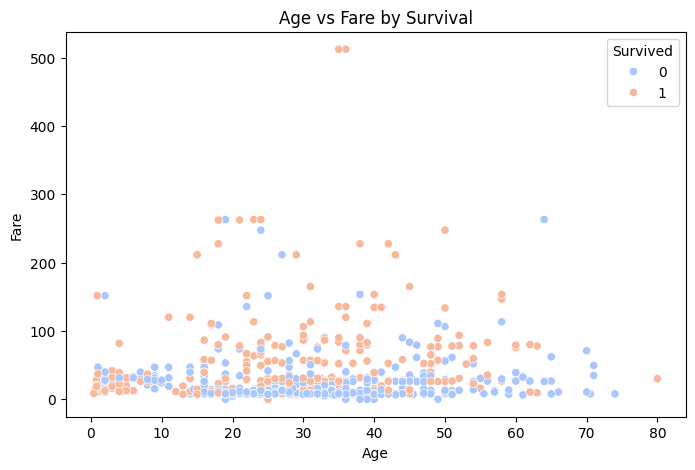

In [11]:
# Visualizing Age vs Fare to spot survival clusters and outliers
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_data, palette='coolwarm')
plt.title('Age vs Fare by Survival')
plt.show()

In [12]:
train_data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [13]:
# Dropping columns that don’t help prediction or have too many missing values
train_data.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

In [14]:
train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [15]:
# Filling missing Age with median
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)

# Filling missing Embarked with mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)


In [16]:
# Encoding Sex and Embarked for modeling
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


In [17]:
train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0
887,888,1,1,1,19.0,0,0,30.0000,0
888,889,0,3,1,28.0,1,2,23.4500,0
889,890,1,1,0,26.0,0,0,30.0000,1


In [18]:
# Cleaning test data before modeling — must match train_data format for consistent predictions
test_data.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True, errors='ignore')

# Filling missing Age with median
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

# Filling missing Fare with median (test_data has Fare NaNs too)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

# Filling missing Embarked with mode
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# Encoding categorical features
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})
test_data['Embarked'] = test_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


In [19]:
test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...,...
413,1305,3,0,27.0,0,0,8.0500,0
414,1306,1,1,39.0,0,0,108.9000,1
415,1307,3,0,38.5,0,0,7.2500,0
416,1308,3,0,27.0,0,0,8.0500,0


In [20]:
from sklearn.model_selection import train_test_split

# Define features and target
X = train_data.drop(['Survived', 'PassengerId'], axis=1)
y = train_data['Survived']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Initialize and train LightGBM
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on test split
lgbm_preds = lgbm_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [22]:
# LightGBM scores
lgbm_accuracy = accuracy_score(y_test, lgbm_preds)
lgbm_precision = precision_score(y_test, lgbm_preds)
lgbm_recall = recall_score(y_test, lgbm_preds)
lgbm_f1 = f1_score(y_test, lgbm_preds)

# XGBoost scores
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)

# Print results
print("LightGBM:")
print(f"Accuracy: {lgbm_accuracy:.4f}")
print(f"Precision: {lgbm_precision:.4f}")
print(f"Recall: {lgbm_recall:.4f}")
print(f"F1 Score: {lgbm_f1:.4f}\n")

print("XGBoost:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")

LightGBM:
Accuracy: 0.8268
Precision: 0.7945
Recall: 0.7838
F1 Score: 0.7891

XGBoost:
Accuracy: 0.8045
Precision: 0.7671
Recall: 0.7568
F1 Score: 0.7619


In [23]:
# Predicting survival using LightGBM on cleaned test_data
final_preds = lgbm_model.predict(test_data.drop('PassengerId', axis=1))

# Preparing submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': final_preds
})

# Preview the first few rows
print(submission.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         0


In [44]:
# Building a simple table to compare LightGBM and XGBoost across key metrics
metrics_df = pd.DataFrame({
    'LightGBM': [lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1],
    'XGBoost': [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Showing the table so we can visually confirm the scores
print("Model Performance Comparison:")
display(metrics_df)

Model Performance Comparison:


,LightGBM,XGBoost
Accuracy,0.826816,0.804469
Precision,0.794521,0.767123
Recall,0.783784,0.756757
F1 Score,0.789116,0.761905


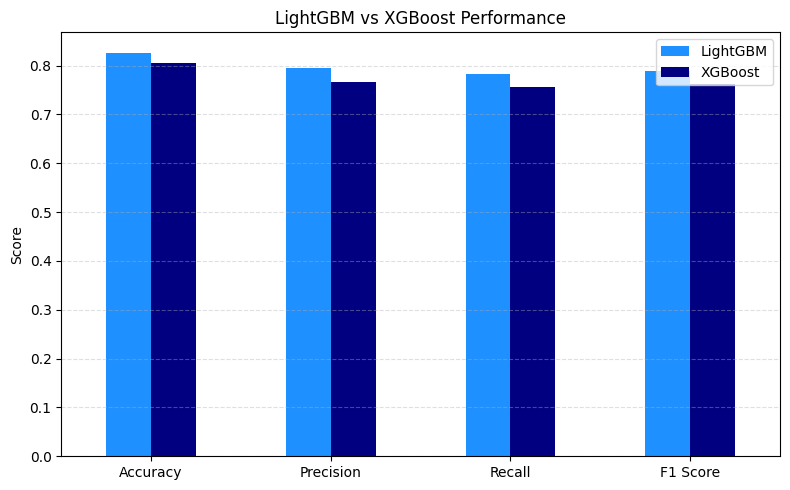

In [45]:
# Visualizing the metric comparison using custom colors (dodgerblue for LightGBM, navy for XGBoost)
metrics_df.plot(kind='bar', figsize=(8, 5), color=['dodgerblue', 'navy'])

# Adding chart labels and layout tweaks
plt.title('LightGBM vs XGBoost Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

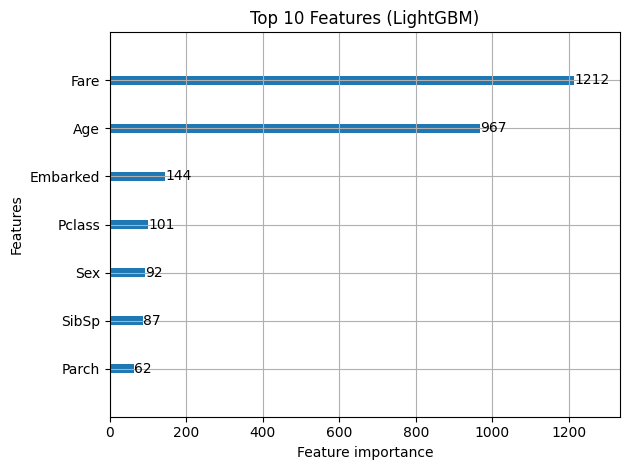

In [46]:
# Plotting top 10 features based on LightGBM’s internal importance scores
plt.figure(figsize=(8, 5))
lgb.plot_importance(lgbm_model, max_num_features=10)

# Adding title and layout fix
plt.title('Top 10 Features (LightGBM)')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

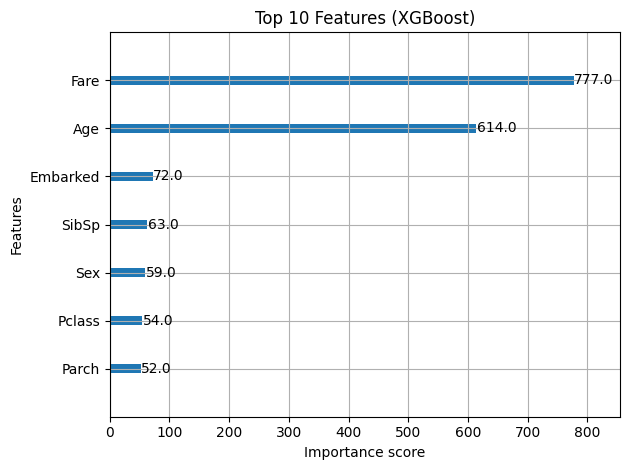

In [49]:
from xgboost import plot_importance

# Plotting top 10 features based on XGBoost’s internal importance scores
plt.figure(figsize=(8, 5))
plot_importance(xgb_model, max_num_features=10)

# Adding title and layout fix
plt.title('Top 10 Features (XGBoost)')
plt.tight_layout()
plt.show()

##Report Summary

In this assignment, we compared LightGBM and XGBoost classifiers on the Titanic dataset. After thorough EDA and preprocessing, both models were trained and evaluated using accuracy, precision, recall, and F1-score. LightGBM showed superior performance across all metrics. The results suggest that LightGBM is better suited for this dataset’s structure and feature distribution. This comparative analysis highlights the importance of model selection and evaluation in predictive analytics.
